In [2]:
import json
from glob import glob
from os.path import join as pjoin
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

from match_elements.GUI_pair import GUIPair
from GUI import GUI
from Operation import Operation

In [3]:
from keras.applications.resnet import ResNet50
resnet_model = ResNet50(include_top=False, input_shape=(32, 32, 3))

In [4]:
from paddleocr import PaddleOCR
paddle_ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2022/03/02 12:19:39] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2022/03/02 12:19:39] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2022/03/02 12:19:39] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/ml/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/ml/.paddleocr/2.3.0.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_s

In [5]:
# load operations
testing_data_root = '/home/ml/Data/visual testing/experiments/humanoid-output/adguard-1'

steps_file = pjoin(testing_data_root, 'output.json')
steps = json.load(open(steps_file, 'r'))

operations = []
for step in steps:
    op = Operation(pjoin(testing_data_root, step['tag'] + '.jpg'), step['event_type'], step['bounds'])
    op.shrink_target_element_img()
    op.resize(int(op.ui_img_width * (800 / op.ui_img_height)), 800)        
    op.detect_text(paddle_ocr)
    operations.append(op)
#     op.show_target_ele()
    break

[2022/03/02 12:19:40] root DEBUG: dt_boxes num : 0, elapse : 0.0260469913482666
[2022/03/02 12:19:40] root DEBUG: cls num  : 0, elapse : 0
[2022/03/02 12:19:40] root DEBUG: rec_res num  : 0, elapse : 1.430511474609375e-06
[Text Detection Completed in 0.028 s] Input: data/operation/target.png Output: data/operation/target.json


In [6]:
opr = operations[0]
opr.show_target_ele()

[2022/03/02 12:26:46] root DEBUG: dt_boxes num : 0, elapse : 0.1720600128173828
[2022/03/02 12:26:46] root DEBUG: cls num  : 0, elapse : 0
[2022/03/02 12:26:46] root DEBUG: rec_res num  : 0, elapse : 1.430511474609375e-06
[Text Detection Completed in 0.192 s] Input: data/output/temp.jpg Output: data/output/ocr/temp.json
[Compo Detection Completed in 0.544 s] Input: data/output/temp.jpg Output: data/output/ip/temp.json
[Merge Completed] Input: data/output/temp.jpg Output: data/output/merge/temp.jpg
No matched element found


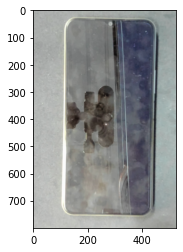

In [7]:
# ********************************************
# *** Streaming Detection with Key Control ***
# ********************************************
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

while(1):
    ret, frame = cap.read()
    frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    frame = frame[80:900, :]
    
    cv2.imshow('camera', frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    elif key == ord('s'):
        cv2.imwrite('data/output/temp.jpg', frame)
        
        # 1. detect GUI element in the frame         
        gui = GUI('data/output/temp.jpg')
        gui.detect_element(True, True, True, paddle_cor=paddle_ocr)
        cv2.imshow('result', gui.det_result_imgs['merge'])
        
        # 2. focus on the screen region and adjust all elements
        gui.adjust_elements_by_screen()
        gui.match_elements(target_ele_img=opr.target_element_img, target_ele_text=opr.get_text_content(), resnet_model=resnet_model, show=True)
        
        print('===================\n')
cap.release()
cv2.destroyAllWindows()

In [4]:
# ***************************
# *** Streaming Detection ***
# ***************************
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

while(1):
    ret, frame = cap.read()
    frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    frame = frame[80:900, :]
    
#     cv2.imshow('camera', frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    cv2.imwrite('data/output/temp.jpg', frame)
    gui = GUI('data/output/temp.jpg')
    gui.detect_element(True, True, True, paddle_cor=paddle_ocr)
    gui.recognize_phone_screen()
    cv2.imshow('camera', gui.det_result_imgs['merge'])
    cv2.imshow('screen', gui.draw_screen(show=False))
    print('===================\n')
cap.release()
cv2.destroyAllWindows()

[2022/03/01 21:55:58] root DEBUG: dt_boxes num : 4, elapse : 0.18249082565307617
[2022/03/01 21:55:58] root DEBUG: cls num  : 4, elapse : 0.01497507095336914
[2022/03/01 21:55:58] root DEBUG: rec_res num  : 4, elapse : 0.04303288459777832
[Text Detection Completed in 0.255 s] Input: data/output/temp.jpg Output: data/output/ocr/temp.json
[Compo Detection Completed in 0.483 s] Input: data/output/temp.jpg Output: data/output/ip/temp.json
[Merge Completed] Input: data/output/temp.jpg Output: data/output/merge/temp.jpg

[2022/03/01 21:55:59] root DEBUG: dt_boxes num : 13, elapse : 0.14171838760375977
[2022/03/01 21:55:59] root DEBUG: cls num  : 13, elapse : 0.04781770706176758
[2022/03/01 21:55:59] root DEBUG: rec_res num  : 13, elapse : 0.08809828758239746
[Text Detection Completed in 0.294 s] Input: data/output/temp.jpg Output: data/output/ocr/temp.json
[Compo Detection Completed in 0.489 s] Input: data/output/temp.jpg Output: data/output/ip/temp.json
[Merge Completed] Input: data/output/

In [ ]:
# *******************************
# *** Adjust Video Clip Range ***
# *******************************

import cv2

def nothing(x):
    pass

cv2.namedWindow('win')
cv2.createTrackbar('top', 'win', 80, 960, nothing)
cv2.createTrackbar('left', 'win', 0, 540, nothing)
cv2.createTrackbar('bottom', 'win', 900, 960, nothing)
cv2.createTrackbar('right', 'win', 540, 540, nothing)

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

while(1):
    ret, frame = cap.read()
    frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    
    top = cv2.getTrackbarPos('top', 'win')
    left = cv2.getTrackbarPos('left', 'win')
    bottom = cv2.getTrackbarPos('bottom', 'win')
    right = cv2.getTrackbarPos('right', 'win')
    
    frame_clip = frame[top:bottom, left:right]
    cv2.imshow('frame', frame)
    cv2.imshow('clip', frame_clip)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()